In [1]:
from primatenet import PrimateNet
import os 
from torch.utils.data import Dataset, DataLoader
from os.path import join
import pandas as pd 
from PIL import Image
from torch.optim import SGD
from detectors import EnsembleDetector, SemanticDetector
import torchvision
from torchvision.transforms import ToTensor, Resize, Compose
import torch 
from torch.utils.data import DataLoader
import torch
import numpy as np
import random
from torchvision.transforms.functional import InterpolationMode

os.environ["CUDA_VISIBLE_DEVICES"] = "GPU-bb1ccb6e-2bc9-c7a1-b25d-3eef9033e192"


device="cuda:0"
root = "data/"
dataset_root = "./data/"
imagenet_root = "/data_slow/kirchheim/datasets/imagenet-2012"

In [2]:
from pytorch_ood.utils import fix_random_seed
import seaborn as sb 

fix_random_seed(123)
sb.set()
g = torch.Generator()
g.manual_seed(0)

In [4]:
from functools import partial

# add feature forward method to all models 
def myfeatures(self, x):
    x = self.features(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    return x 

In [5]:
from preset import ClassificationPresetEval, ClassificationPresetTrain

trans = ClassificationPresetTrain(
                crop_size=224, # 224,
                interpolation=InterpolationMode.BILINEAR,
                auto_augment_policy=None,
                random_erase_prob=0.0,
                ra_magnitude=9,
                augmix_severity=3,
                backend="PIL",
        )

test_trans = ClassificationPresetEval(
                crop_size=224, # 224,
                interpolation=InterpolationMode.BILINEAR,
                backend="PIL",
        )

In [6]:
def eval_acc(model, att_index):
    model.eval()
    test_data = PrimateNet(root=imagenet_root, transform=test_trans, train=False)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=16, worker_init_fn=fix_random_seed)
    
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()

        for inputs, y in test_loader:
            labels = y[:, att_index]
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {correct / total:.2%}')
    
    

In [7]:
from tqdm.notebook import tqdm 
import numpy as np 
from torchvision.models import resnet18, ResNet18_Weights, vit_h_14, ViT_H_14_Weights, efficientnet_v2_l, EfficientNet_V2_L_Weights
from torch import nn 


def train_model(att_index, num_classes, epochs=1):
    """
    train a model for the given attribute index 
    """
    # trans =  trans # ResNet18_Weights.DEFAULT.transforms()
    train_data = PrimateNet(root=imagenet_root, transform=trans, train=True)
    test_data = PrimateNet(root=imagenet_root, transform=test_trans, train=False)
    
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=16, worker_init_fn=fix_random_seed)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=16, worker_init_fn=fix_random_seed)
    
    # model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model = efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.DEFAULT)
    # model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    # model.fc = model.heads.head

    # model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    model.fc = model.classifier[1] 
    
    _ = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), 
                    lr=0.001, momentum=0.9,  nesterov=True,  weight_decay=1e-4) #
    
     
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs, eta_min=0.00001
        )
    
    accs = []

    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        bar = tqdm(train_loader)
        for inputs, y in bar:
            labels = y[:, att_index]
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss = 0.8 * running_loss + 0.2 * loss.item()
            bar.set_postfix({"loss": running_loss})
        
        scheduler.step()
        
        eval_acc(model, att_index)
        model.train()

    return model 

In [8]:
from primatenet import PrimateNetOOD


def train_oe_model(epochs=1):
    """
    train a model for outlier exposure 
    """
    train_data = PrimateNet(root=imagenet_root, transform=trans, train=True, target_transform=lambda x: 1)
    test_data = PrimateNet(root=imagenet_root, transform=test_trans, train=False, target_transform=lambda x: 1)
    test_data_ood = PrimateNetOOD(root=imagenet_root, train=False, transform=trans, target_transform=lambda x: 0)
    train_data_ood = PrimateNetOOD(root=imagenet_root, train=True, transform=trans, target_transform=lambda x: 0)
       
    train_loader = DataLoader(train_data + train_data_ood, batch_size=16, shuffle=True, num_workers=16, worker_init_fn=fix_random_seed)
    test_loader = DataLoader(test_data + test_data_ood, batch_size=16, shuffle=False, num_workers=16, worker_init_fn=fix_random_seed)
    
    model = efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2) # binary 
    model.fc = model.classifier[1] 
    
    _ = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), 
                    lr=0.001, momentum=0.9,  nesterov=True,  weight_decay=1e-4) #
    
     
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs, eta_min=0.00001
        )
    
    accs = []

    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        bar = tqdm(train_loader)
        for inputs, y in bar:
            labels = y
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss = 0.8 * running_loss + 0.2 * loss.item()
            bar.set_postfix({"loss": running_loss})
        
        scheduler.step()
        
        correct = 0
        total = 0

        with torch.no_grad():
            model.eval()

            for inputs, y in test_loader:
                labels = y
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
        print(f'Accuracy of the network on the test images: {correct / total:.2%}')

    return model 

In [30]:
from pytorch_ood.dataset.img import Textures, ImageNetO, FoolingImages, ImageNetR, ImageNetA
from pytorch_ood.detector import EnergyBased, MaxSoftmax, Mahalanobis, ViM, KLMatching, MaxLogit, Entropy
from pytorch_ood.utils import ToRGB, OODMetrics, ToUnknown


def extract(models):
    
    global dataset_all_logits_cache
    global dataset_features_cache
    global dataset_labels_cache
    global train_features_cache 
    global train_labels_cache 
    global dataset_oe_logits_cache
    
    for model in models:
        model.eval()
    
    # TODO 
    label_net = models[0]

    trans = Compose([ToRGB(), EfficientNet_V2_L_Weights.DEFAULT.transforms()])
  
    train_data = PrimateNet(root=imagenet_root, transform=trans, target_transform=lambda y: int(y[0]), train=True)
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=16, worker_init_fn=fix_random_seed)
    
    print("Extracting features for training")
    if train_features_cache is not None and train_labels_cache is not None:
        pass 
    else:
        with torch.no_grad():
            features, ys = [], []
            for x, y in train_loader:
                features.append(label_net.myfeatures(x.to(device)))
                ys.append(y.to(device))
            features, ys = torch.cat(features, dim=0).cpu(), torch.cat(ys, dim=0).cpu()
            
            # update cache 
            train_features_cache = features 
            train_labels_cache = ys 

    
    # PREDICT 
    datasets = {d.__name__: d for d in (FoolingImages, Textures, ImageNetO, ImageNetR, ImageNetA)}
    data_in = PrimateNet(root=imagenet_root, transform=trans, train=False, target_transform=lambda y: int(y[0]))
        
    with torch.no_grad():
        for data_name, dataset_c in datasets.items():
            data_out = dataset_c(root=dataset_root, transform=trans, target_transform=ToUnknown(), download=True)
            loader = DataLoader(data_in+data_out, batch_size=256, shuffle=False, worker_init_fn=fix_random_seed)

            print("Extracting logits from all models")
            if data_name in dataset_all_logits_cache:
                pass
            else:
                labels, all_logits = [], []
                for n, model in enumerate(models):
                    print(f"Model {n}")
                    
                    logits, ys = [], []
                    for x, y in loader:
                        logits.append(model(x.to(device)))
                        ys.append(y.to(device))
                    logits, ys = torch.cat(logits, dim=0).to(device), torch.cat(ys, dim=0).to(device)
                    
                    all_logits.append(logits)
                    labels.append(ys)
                
                # update cache 
                print(f"{len(labels)=}")
                print(f"{len(all_logits)=}")
                dataset_labels_cache[data_name] = labels 
                dataset_all_logits_cache[data_name] = all_logits
                
            print("Extracting OE Logits")
            if data_name in dataset_oe_logits_cache:
                pass
            else:
                logits = []
                for x, y in loader:
                    logits.append(oe_model(x.to(device)))
                oe_logits = torch.cat(logits, dim=0).to(device)
                print(f"{len(oe_logits)=}")
                dataset_oe_logits_cache[data_name] = oe_logits 

            print("Extracting deep features")
            if data_name in dataset_features_cache:
                pass
            else:
                deep_features = []
                for x, y in loader:
                    deep_features.append(label_net.myfeatures(x.to(device)))
                deep_features = torch.cat(deep_features, dim=0).to(device)
                
                # update cache 
                dataset_features_cache[data_name] = deep_features
    return 


def fit(models):
    global train_features_cache 
    global train_labels_cache 
    
    for model in models:
        model.eval()
        
    label_net = models[0]
    
    detectors = {
        "Structured": PrimanetSemanticDetector(models),
        "Structured-OE": PrimanetSemanticDetector(models, oe_model=oe_model),
        "Ensemble": EnsembleDetector([MaxSoftmax(model) for model in models]),
        "MSP": MaxSoftmax(label_net),
        "Energy": EnergyBased(label_net),
        "Mahalanobis": Mahalanobis(label_net.myfeatures, eps=0),
        "ViM": ViM(label_net.myfeatures, w=label_net.fc.weight, b=label_net.fc.bias, d=64),
        "Entropy": Entropy(label_net),
        "MaxLogit": MaxLogit(label_net),
    }
    
    features = train_features_cache
    ys = train_labels_cache
        
    print(f"Classes in fitting data: {ys.unique()}")
    for name in ["ViM", "Mahalanobis", "KLMatching"]:
        if name in detectors:
            print(f"Fitting {name}")
            try:
                detectors[name].fit_features(features, ys, device=device)
            except TypeError:
                detectors[name].fit_features(features, ys)
                
    return detectors 


def evaluate(detectors):
    global dataset_all_logits_cache
    global dataset_features_cache
    global dataset_labels_cache
    global dataset_oe_logits_cache
    
    results = []
        
    with torch.no_grad():
        for data_name in dataset_all_logits_cache.keys():
            deep_features = dataset_features_cache[data_name]
            oe_logits = dataset_oe_logits_cache[data_name]
            labels = dataset_labels_cache[data_name]
            all_logits = dataset_all_logits_cache[data_name]
            
            # evaluate 
            for detector_name, detector in detectors.items():
                
                print(f"{data_name} - {detector_name}")
                if detector_name in  ["ViM", "Mahalanobis"]:
                    scores = detector.predict_features(deep_features)

                elif detector_name in ["Structured", "Ensemble", "Structured-Entropy"]:
                    scores = detector.predict_features(all_logits)
                
                elif detector_name in ["Structured-OE"]:
                    scores = detector.predict_features(all_logits, oe_features=oe_logits)
                    
                else:
                    scores = detector.predict_features(all_logits[0])

                metrics = OODMetrics()
                # labels[0] contains class labels 
                metrics.update(scores, labels[0])
                r = metrics.compute()
                r.update({
                    "Method": detector_name,
                    "Dataset": data_name
                })
                print(r)
                results.append(r)
    
    return results 

In [26]:
from functools import partial 
from primatenet import PrimateNet, PrimateNetOOD

dataset_all_logits_cache = None 
dataset_features_cache = None 
dataset_oe_logits_cache = None 
dataset_labels_cache = None 
train_features_cache = None 
train_labels_cache = None 
    
# if False: # safeguard 
def clear_cache():
    global dataset_all_logits_cache
    global dataset_features_cache
    global dataset_labels_cache
    global train_features_cache 
    global train_labels_cache 
    global dataset_oe_logits_cache
    
    dataset_all_logits_cache = {}
    dataset_features_cache = {}
    dataset_oe_logits_cache = {}
    dataset_labels_cache = {}
    train_features_cache = None 
    train_labels_cache = None 


atts = ["class", "great_ape", "lesser_ape", "ape", "lemur", "old_world_monkey", "new_world_monkey", "monkey"]

results = []

n_epochs = 20

for seed in range(10):
    
    for model in models: 
        model.cpu()
        
    models = []
    
    if True:
        # train new model 
        for i, att in enumerate(atts):
            print(f"Training model for {att}")
            if att == "class":
                num_classes = 16
            else:
                num_classes = 2 

            model = train_model(i, num_classes=num_classes, epochs=n_epochs)
            torch.save(model.cpu(), f"data/model-{att}.pt")

        oe_model = train_oe_model(epochs=n_epochs)
        torch.save(oe_model.cpu(), f"data/model-oe.pt")
        models.append(models)

    if True:
        # load saved model 
        models = []
        for i, att in enumerate(atts):
            print(f"Loading model for {att}")
            model = torch.load(f"data/model-{att}.pt")
            model.to(device)

            eval_acc(model, i)
            models.append(model)    

        print(f"Loading model for oe")
        oe_model = torch.load(f"data/model-oe.pt").to(device)

    
    # patch models 
    for model in models: 
        model.myfeatures = partial(myfeatures, model)

    oe_model.myfeatures = partial(myfeatures, model)
    
    
    extract(models)
    detectors = fit(models)
    result = evaluate(detectors)
    
    for r in result:
        r.update({
            "Seed": seed
        })
    
    results += result 
    
    clear_cache()
    

In [33]:
import seaborn as sb 
import pandas as pd 

In [35]:
import pandas as pd 
result_df = pd.DataFrame(result)
mean = (result_df.groupby(by=["Method"]).mean() * 100).groupby("Method").agg(["mean", "sem"])[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]]
mean
print(mean.sort_values(by=("AUROC", "mean")).to_latex(float_format="%.2f").replace("NaN", "$\pm$ ?"))

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95TPR} \\
{} &  mean & sem &    mean & sem &     mean & sem &     mean & sem \\
Method        &       &     &         &     &          &     &          &     \\
\midrule
Structured    & 94.23 & $\pm$ ? &   98.82 & $\pm$ ? &    88.86 & $\pm$ ? &    10.82 & $\pm$ ? \\
Structured-OE & 95.84 & $\pm$ ? &   99.38 & $\pm$ ? &    92.58 & $\pm$ ? &     8.43 & $\pm$ ? \\
Ensemble      & 97.48 & $\pm$ ? &   99.48 & $\pm$ ? &    91.36 & $\pm$ ? &     8.15 & $\pm$ ? \\
MSP           & 98.34 & $\pm$ ? &   99.77 & $\pm$ ? &    90.05 & $\pm$ ? &     7.72 & $\pm$ ? \\
Entropy       & 98.96 & $\pm$ ? &   99.87 & $\pm$ ? &    92.01 & $\pm$ ? &     4.28 & $\pm$ ? \\
MaxLogit      & 99.23 & $\pm$ ? &   99.91 & $\pm$ ? &    94.04 & $\pm$ ? &     3.43 & $\pm$ ? \\
Mahalanobis   & 99.24 & $\pm$ ? &   99.89 & $\pm$ ? &    95.48 & $\pm$ ? &     3.83 & $\pm$ ? \\

/tmp/ipykernel_348151/1449753543.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean = (result_df.groupby(by=["Method"]).mean() * 100).groupby("Method").agg(["mean", "sem"])[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]]
/tmp/ipykernel_348151/1449753543.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(mean.sort_values(by=("AUROC", "mean")).to_latex(float_format="%.2f").replace("NaN", "$\pm$ ?"))


In [36]:
import matplotlib.pyplot as plt 
# Use plot styling from seaborn.
sb.set(style='darkgrid')

# Increase the plot size and font size.
sb.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


In [37]:
detector = PrimanetSemanticDetector(models=models)

features = dataset_all_logits_cache["ImageNetO"]
ys = dataset_labels_cache["ImageNetO"][0].cpu()

features = [f.cpu() for f in features]

scores = detector._get_detector_score(features)
# scores += scores.min()
# scores /= scores.max()
y_hat, world_models = detector._get_world_models(features)
consistent = detector._check_consistency(y_hat, world_models)
total = scores * consistent + 1 
    

feature.shape=torch.Size([2800, 16])
feature.shape=torch.Size([2800, 2])
feature.shape=torch.Size([2800, 2])
feature.shape=torch.Size([2800, 2])
feature.shape=torch.Size([2800, 2])
feature.shape=torch.Size([2800, 2])
feature.shape=torch.Size([2800, 2])
feature.shape=torch.Size([2800, 2])


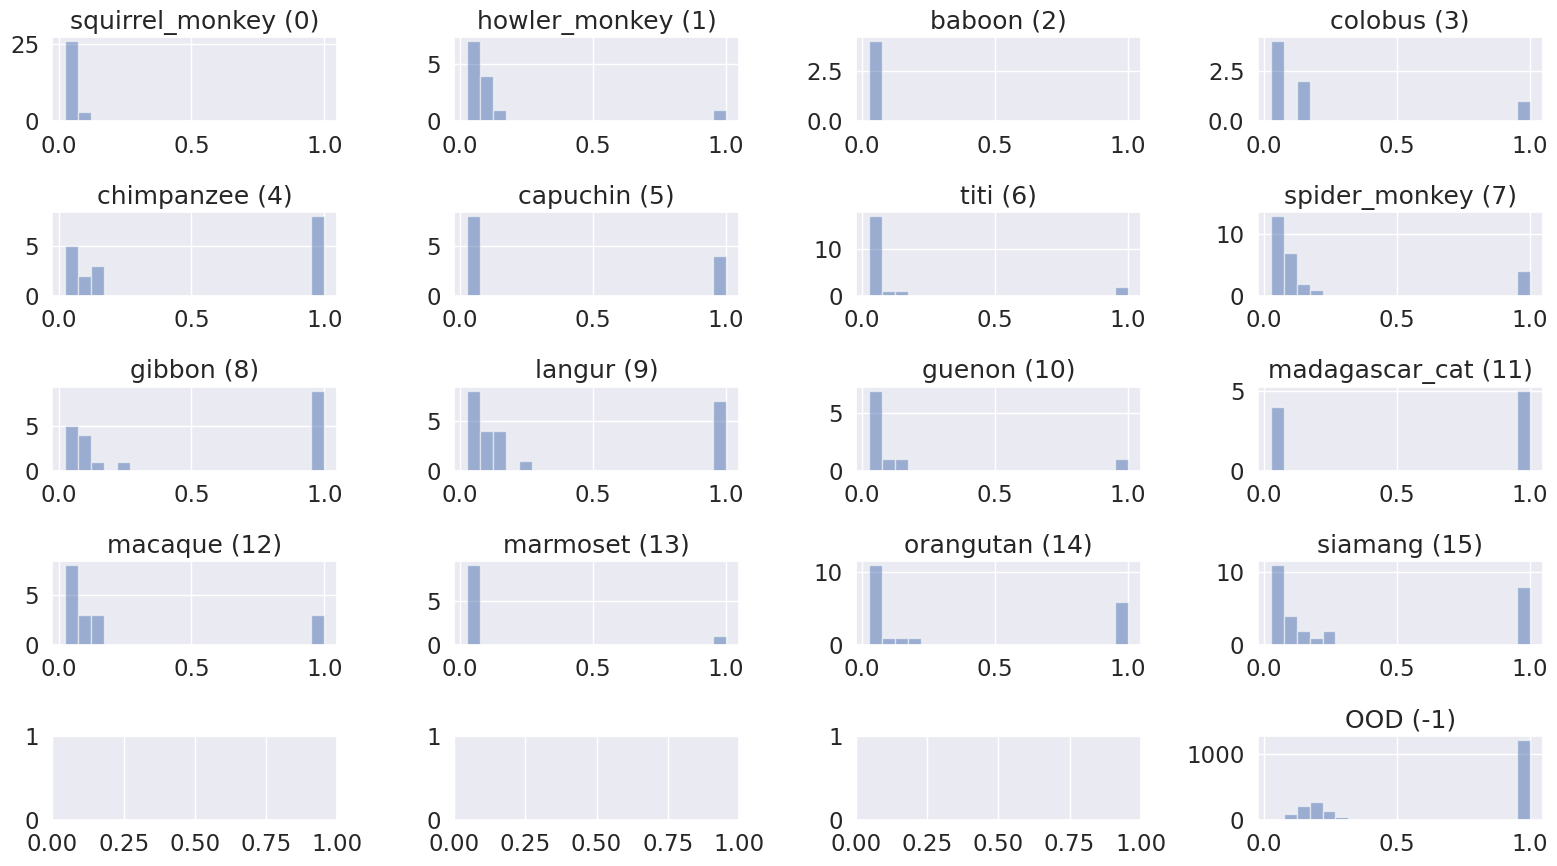

In [38]:
class_idx_to_name = {i[1]: i[0] for i in PrimateNet.data.values()}
# class_idx_to_name.update({-1: "OOD"})

fig, axs = plt.subplots(5,4, figsize=(16,9))

axs = axs.flatten()

bins = 20 

known = ys >= 0 

for clazz in ys.unique():
    idx = ys == clazz
    
    _, bins, _ = axs[clazz].hist(total[idx].numpy(), alpha=0.5, bins=bins) # , range=[0, 1]
    name = class_idx_to_name[clazz.item()] if clazz.item() in class_idx_to_name else "OOD"
    axs[clazz].set_title(f"{name} ({clazz.item()})")
    
    # plt.title(str(clazz))
plt.tight_layout()
plt.show()


In [39]:
detector = PrimanetSemanticDetector(models=models, oe_model=oe_model)

features = dataset_all_logits_cache["ImageNetO"]
oe_features = dataset_oe_logits_cache["ImageNetO"]
ys = dataset_labels_cache["ImageNetO"][0].cpu()

features = [f.cpu() for f in features]

scores = detector._get_detector_score(features)
# scores += scores.min()
# scores /= scores.max()
y_hat, world_models = detector._get_world_models(features)
consistent = detector._check_consistency(y_hat, world_models)

oe_consistent = oe_features.argmax(dim=1).long() # assuming positive class is one 
consistent = consistent & oe_consistent.cpu()
        
total = scores * consistent + 1 

feature.shape=torch.Size([2800, 16])
feature.shape=torch.Size([2800, 2])
feature.shape=torch.Size([2800, 2])
feature.shape=torch.Size([2800, 2])
feature.shape=torch.Size([2800, 2])
feature.shape=torch.Size([2800, 2])
feature.shape=torch.Size([2800, 2])
feature.shape=torch.Size([2800, 2])


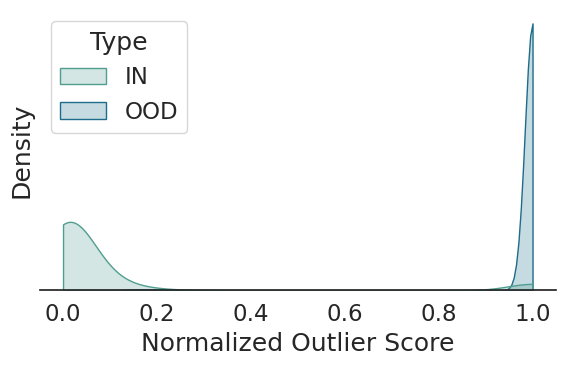

In [66]:
from pytorch_ood.utils import is_known
sb.set_style("white")

df = pd.DataFrame({"Scores": total.numpy(), "label": ys})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")

fig, ax = plt.subplots(figsize=(6,4))

sb.kdeplot(data=df, x="Scores", clip=[0,1], common_norm=False, fill=True, hue="Type", palette="crest", bw_method=0.2) # , palette="crest" # , 
sb.move_legend(ax, "upper left")
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True, bottom=False)
plt.xlim([-0.05,1.05])
plt.yticks([])
plt.tight_layout()


plt.savefig("../img/primatenet-semantic.pdf", bbox_inches="tight")

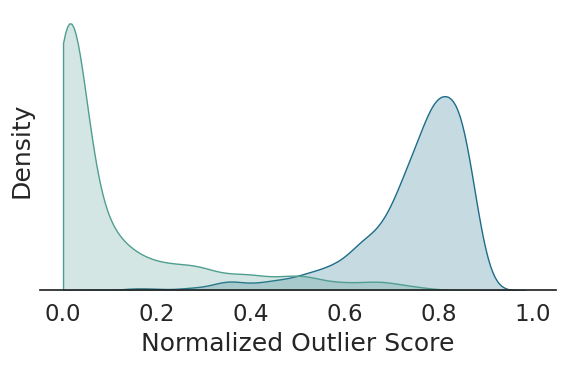

In [65]:

msp = MaxSoftmax(models[0])
features = dataset_all_logits_cache["ImageNetO"][0]

scores = msp.predict_features(features).cpu()

df = pd.DataFrame({"Scores": scores.numpy() + 1, "label": ys})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")

fig, ax = plt.subplots(figsize=(6,4))

sb.kdeplot(data=df, x="Scores", clip=[0,1], common_norm=False, fill=True, hue="Type", palette="crest", bw_method=0.2, legend=None) # , palette="crest" # , 
plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True)
plt.xlim([-0.05,1.05])
plt.yticks([])
plt.tight_layout()

plt.savefig("../img/primatenet-msp.pdf", bbox_inches="tight")
